In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
conn = engine.connect()

In [7]:
Base = automap_base()

In [8]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)
for row in session.query(Measure, Station).limit(5).all():
    print(row)

(<sqlalchemy.ext.automap.measurement object at 0x0000025293158408>, <sqlalchemy.ext.automap.station object at 0x0000025293158548>)
(<sqlalchemy.ext.automap.measurement object at 0x0000025293158408>, <sqlalchemy.ext.automap.station object at 0x00000252931586C8>)
(<sqlalchemy.ext.automap.measurement object at 0x0000025293158408>, <sqlalchemy.ext.automap.station object at 0x0000025293158748>)
(<sqlalchemy.ext.automap.measurement object at 0x0000025293158408>, <sqlalchemy.ext.automap.station object at 0x00000252931587C8>)
(<sqlalchemy.ext.automap.measurement object at 0x0000025293158408>, <sqlalchemy.ext.automap.station object at 0x0000025293158848>)


In [12]:
Measure_df = pd.read_sql("SELECT * FROM measurement", conn)
Station_df = pd.read_sql("SELECT * FROM station", conn)

In [13]:
Station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [14]:
Measure_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [42]:
Measure_df.date.max()

'2017-08-23'

# Exploratory Climate Analysis

In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
resultsd=session.query(Measure.date).order_by(Measure.date.desc()).first()
onedate=list(np.ravel(resultsd))[0]
latedate=dt.datetime.strptime(onedate,"%Y-%m-%d")
year_back=latedate-dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
results=session.query(Measure.date, Measure.prcp).order_by(Measure.date.asc()).\
        filter(Measure.date>=year_back).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df_qresults=pd.DataFrame(results)
df_qresults=df_qresults.rename(columns={"prcp":"precipitation"})
# Sort the dataframe by date
df_qresults.sort_values(by=['date'], ascending=True)
df_qresults=df_qresults.dropna()
df_qresults=df_qresults.reset_index(drop=True)

df_qresults.head()

,date,precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,1.22
4,2016-08-24,2.15


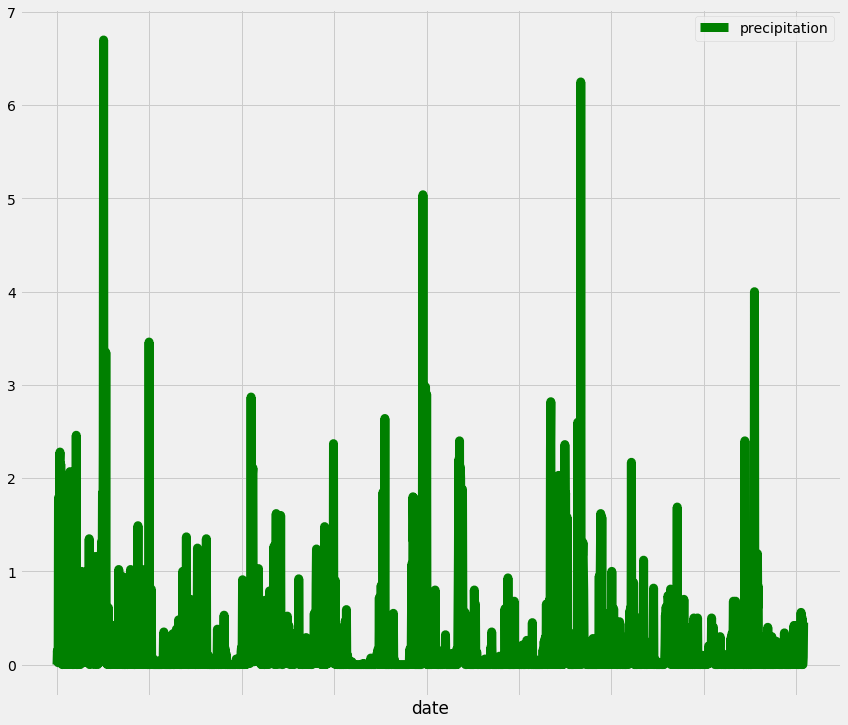

In [31]:
# Use Pandas Plotting with Matplotlib to plot the data
ax=df_qresults.plot(color='g',figsize=(12,10),legend=True,linewidth=9.0,grid=True)
#Removing xticks
plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.xlabel("date")
plt.show()

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_qresults.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Design a query to show how many stations are available in this dataset?

station_count=session.query(func.count(Station.id)).all()
station_count

[(9)]

In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_measure=session.query(Measure.station,func.count(Measure.station)).\
                       group_by(Measure.station).\
                       order_by(func.count(Measure.station).desc()).all()
station_measure


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
rec_temp=session.query(func.min(Measure.tobs), func.max(Measure.tobs), func.avg(Measure.tobs)).\
             filter(Measure.station==station_measure[0][0]).all()
rec_temp

[(54.0, 85.0, 71.66378066378067)]

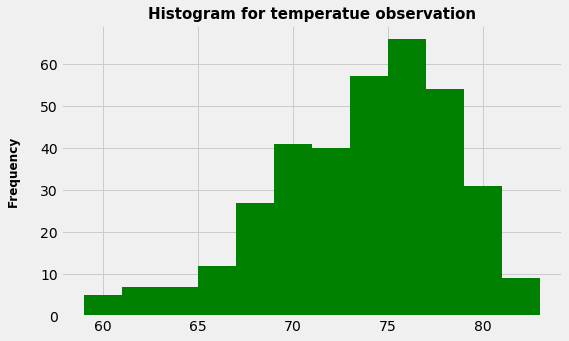

In [44]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results_date=session.query(Measure.date).order_by(Measure.date.desc()).\
             filter(Measure.station==station_measure[0][0]).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=365)

results_temp=session.query(Measure.tobs).\
             filter(Measure.station==station_measure[0][0]).\
             filter(Measure.date>=year_back).all()
df_qresults2=pd.DataFrame(results_temp)


#Plotting Histogram
hist = df_qresults2['tobs'].hist(bins=12,figsize=(8,5), color='g', zorder=2)

# Remove title
hist.set_title("Histogram for temperatue observation",weight='bold', size=15)

# Set y-axis label
hist.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

plt.show()

## Bonus Challenge Assignment

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)).\
        filter(Measure.date >= start_date).filter(Measure.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [46]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year=year_back.year
start_date=str(prev_year)+'-09-25'
end_date=str(prev_year)+'-10-01'
Temp_holiday=calc_temps(start_date, end_date)
Temp_holiday_avg=Temp_holiday[0][1]
Temp_holiday_error=Temp_holiday[0][2]-Temp_holiday[0][0]


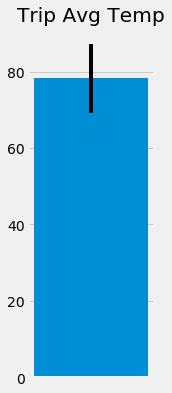

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.subplots(figsize=(2,6))
plt.bar(1,Temp_holiday[0][1],yerr=Temp_holiday_error)
#Removing xticks
plt.xticks([])
plt.title("Trip Avg Temp")
plt.show()

In [49]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel=[Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
station_measure2=session.query(*sel,func.sum(Measure.prcp)).\
                       group_by(Measure.station).\
                       order_by(Measure.station ).\
                       filter(Measure.date>=start_date).\
                       filter(Measure.date<=end_date).\
                       filter(Measure.station==Station.station).all()
                        
station_measure2

[('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  1.2200000000000002),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.36000000000000004),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.04),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.35),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.79)]

In [51]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measure.date) == date).all()
    
daily_normals("09-30")

[(67.0, 75.3061224489796, 83.0)]

In [53]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
#completed above
# Use the start and end date to create a range of dates
results=session.query(Measure.date).order_by(Measure.date.asc()).\
       filter(Measure.date>=start_date).\
       filter(Measure.date<=end_date).distinct()
# Stip off the year and save a list of %m-%d strings
date_trip_df=pd.DataFrame(results.all())
normal=date_trip_df['date'].str.slice(start=5)
date_trip_df = date_trip_df.set_index('date') 
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norms=[]
for month_date in range(len(normal)):
    daily_value=daily_normals(normal[month_date])[0]
    daily_norms.append(tuple(daily_value))
daily_norms

[(69.0, 76.14893617021276, 83.0),
 (66.0, 75.64, 85.0),
 (68.0, 75.64, 83.0),
 (67.0, 76.13461538461539, 84.0),
 (68.0, 75.97872340425532, 83.0),
 (67.0, 75.3061224489796, 83.0),
 (69.0, 75.22916666666667, 80.0)]

In [54]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
data_df=pd.DataFrame(daily_norms)

date_trip_df['tmin']=data_df[0].tolist()
date_trip_df['tavg']=data_df[1].tolist()
date_trip_df['tmax']=data_df[2].tolist()
date_trip_df

,tmin,tavg,tmax
date,,,
2016-09-25,69.0,76.148936,83.0
2016-09-26,66.0,75.640000,85.0
2016-09-27,68.0,75.640000,83.0
2016-09-28,67.0,76.134615,84.0
2016-09-29,68.0,75.978723,83.0
2016-09-30,67.0,75.306122,83.0
2016-10-01,69.0,75.229167,80.0


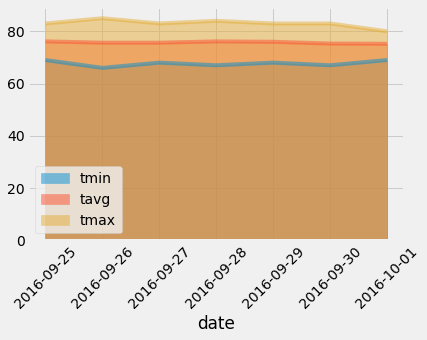

In [55]:
# Plot the daily normals as an area plot with `stacked=False`
ax = date_trip_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.show()